King of the mesa

Dit is een gevolgde tutorial dus heb zelf de code mee getypt/aangepast tijdens het volgen van de tutorial.
als ik alleen mesa importeerde werd er bij meerdere modules gezegd dat ze niet bestonden dus heb ik vanuit mesa de benodigde dingen geimporteerd (aan de hand van de tutorial). 

In [1]:
# all the imports
from mesa import Agent, Model
from mesa.time import RandomActivation
import matplotlib.pyplot as plt
from mesa.space import MultiGrid
import numpy as np
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
from mesa.visualization.ModularVisualization import VisualizationElement


Gini-coeffiecient

Het Gini-coeffiecient is een manier om het vermogenesongelijkheid te weergeven van een populatie. Het getal zit altijd tussen de 0 en de 1. hoe dichterbij de 1 hoe meer ongelijkheid hoe dichter bij de 0 des te minder ongelijkheid. 


https://www.economielokaal.nl/gini-coefficient-23/

In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

MoneyAgent Class

Eerst wordt er gecheckt of een agent 1 of meer wealth heeft, als deze agent dat heeft activeert de functie move. De agent beweegt dan naar een van de 9 naast liggende velden. als de agent op de andere plaats aankomend activeert de functie give_money, dan wordt er gekeken of er meerdere agents in dat vakje staan. Als er meerdere agents op de zelfde locatie staan kiest de agent een random andre agent en geeft hier wealth aan. Als de betreffende agent 0 wealth heeft krijgt die ook nog 1 extra van de 'bank'dus een van een agent en een van de 'bank' om zo de gini coefficiente lager te krijgen. 

MoneyModel Class

het moneymodel wordt levert de agents en de ruimte waarin ze bewegen 10 bij 10. Ook geeft deze class aan dat de agents willekeurig geactiveerd worden. 

In [3]:

class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        random_agent = self.random.choice(cellmates)
        if len(cellmates) > 1:
            if random_agent.wealth == 0:
                random_agent.wealth += 2
                self.wealth -= 1
            else:
                random_agent.wealth += 1
                self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [4]:
# aantal agents, breedte van het veld , hoogte van het veld
model = MoneyModel(50, 10, 10)
# the range determines how many turns 1 agent has, 
# so in this case 50 agents get 100 turn to trade their wealth with eachother
for i in range(100):
    model.step()

hier onder laat zien hoeveel agents er in de omgeving staan na een test. eerst is het bord een lege array en daarna wordt het gevuld met de agents en de data. 

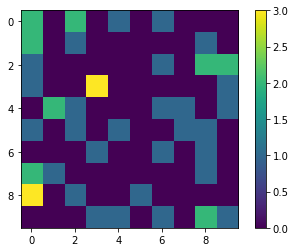

In [5]:
# this shows a map how many agents resides in one square after 100 turns. 
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

Hieronder is de data van de simulatie in een dataframe gedaan. Elke step is een ronde voor elke agent. dus na 100 rondes is er te zien hoeveel wealth elke agent over heeft.

In [6]:
# 
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
...              ...
99   45            6
     46            0
     47            2
     48            5
     49            0

[5000 rows x 1 columns]

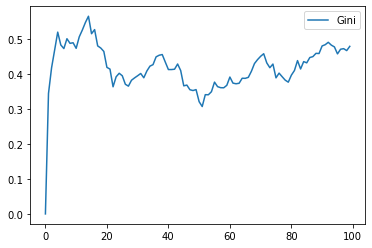

In [7]:
# gini model plotted with the data from the test
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

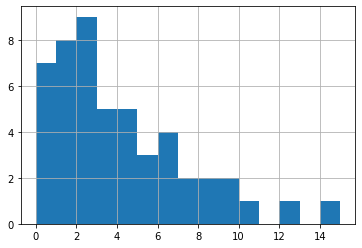

In [8]:
# how much wealth each agent has after this test in step 99 
# so 1 person has 14 wealth and 2 people had 11 wealth
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max() + 1))

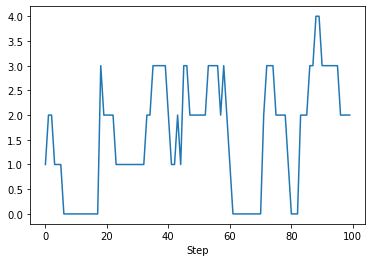

In [9]:
# this is the wealth data from a single agent. agent 36 in this case
one_agent_wealth = agent_wealth.xs(36, level="AgentID")
one_agent_wealth.Wealth.plot()

Hier onder gebeurd een batch run: "Zoals we hierboven vermeldden, zul je een model meestal niet slechts één keer uitvoeren, maar meerdere keren, met vaste parameters om de algemene verdelingen te vinden die het model genereert, en met variërende parameters om te analyseren hoe ze de uitvoer en het gedrag van het model sturen. In plaats van geneste for-loops te moeten schrijven voor elk model, biedt Mesa een batch_run functie die dit voor je automatiseert." van de tutorial. 

In [10]:
# with batch run we run the model more than once to get more data. 
# fixed params stay the same the whole time and the variable change in time
fixed_params = {"width": 10,
               "height": 10} 
variable_params = {"N": range(10, 500, 10)} 

batch_run = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

245it [01:48,  2.25it/s]


In [11]:
# returned data from the batch run
run_data = batch_run.get_model_vars_dataframe()
run_data


,N,Run,Gini,width,height
0,10,0,0.300000,10,10
1,10,1,0.487500,10,10
2,10,2,0.400000,10,10
3,10,3,0.290909,10,10
4,10,4,0.471429,10,10
...,...,...,...,...,...
240,490,240,0.407698,10,10
241,490,241,0.388856,10,10
242,490,242,0.402629,10,10
243,490,243,0.414417,10,10


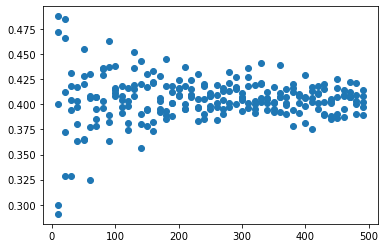

In [12]:
# gini scatter plot with the new batch run data
plt.scatter(run_data.N, run_data.Gini)

De Gui van de advanced tutorial. 

Hier zie je de agents over het bord bewegen en tijdens elke step kan je zien wat voor agents er in een vakje staan aan de hand van de kleur. >0 rood, >3 blauw en < 1 groen. 
Bij de GUI kan je zelf de step grootte instellen en ook per step klikken. 
De Gui kan maar eenmalig launchen anders moet de hele kernel herstart worden. 

In [13]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 3
        portrayal["r"] = 0.5
    if agent.wealth > 3:
        portrayal["Color"] = "Blue"
        portrayal["Layer"] = 2
        portrayal["r"] = 0.75
    if agent.wealth < 1:
        portrayal["Color"] = "green"
        portrayal["Layer"] = 4
        portrayal["r"] = 0.25
        
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)


chart = ChartModule([{"Label": "Gini",
                      "Color": "black"}],
                    data_collector_name='datacollector')

server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
server.port = 8521 # The default
server.launch()


Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
